In [1]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  16


# Package

In [2]:
%pip install tensorflow-gpu==2.9
%pip install tensorflow-text

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import tensorflow_text as tf_text

In [4]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import gc
import numpy as np
from tensorflow import keras
from numpy.ma.core import transpose
from sklearn.model_selection import KFold
from timeit import default_timer as timer
import datetime 
import sys
import time
import psutil
import os

In [6]:
%pip install gensim==3.8
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import gensim.downloader

In [8]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/mobin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2022-11-09 08:38:17.332114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


1 Physical GPUs, 1 Logical GPUs


2022-11-09 08:38:17.406015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 08:38:17.406190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 08:38:17.407767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 08:38:17.410005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [11]:
%pip install tensorboard


Note: you may need to restart the kernel to use updated packages.


In [12]:
%pip install -U tensorboard_plugin_profile


Note: you may need to restart the kernel to use updated packages.


In [13]:
#tf.config.optimizer.set_jit(True)


# **Data Preparation**

In [14]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    name=b'"verified": \"true\",'
    l=l.replace(b'"verified": true,',bytes(name))
    name1=b'"verified": \"false\",'
    l=l.replace(b'"verified": false,',bytes(name))
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/home/mobin/Downloads/reviews_Grocery_and_Gourmet_Food_5.json.gz')

# dataset link
# Grocery and Gourmet Food
# https://jmcauley.ucsd.edu/data/amazon/

Dataset Schema

In [15]:
df.rename(columns={"reviewerID": "userID", "asin": "itemID","overall":"rating"},inplace=True)

df

,userID,itemID,reviewerName,helpful,reviewText,rating,summary,unixReviewTime,reviewTime
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013"
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3.0,"3.5 stars, sadly not as wonderful as I had hoped",1400457600,"05 19, 2014"
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013"
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]","I had never had it before, was curious to see ...",5.0,Unexpected flavor meld,1369008000,"05 20, 2013"
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",I've been looking forward to trying these afte...,4.0,"Not a very strong tea flavor, but still yummy ...",1369526400,"05 26, 2013"
...,...,...,...,...,...,...,...,...,...
151249,A2L6QS8SVHT9RG,B00KCJRVO2,"randomartco ""period film aficionado""","[0, 0]",Delicious gluten-free oatmeal: we tried both t...,4.0,Delicious gluten-free oatmeal 'quick' packs!,1405123200,"07 12, 2014"
151250,AFJFXN42RZ3G2,B00KCJRVO2,"R. DelParto ""Rose2""","[0, 0]",With the many selections of instant oatmeal ce...,4.0,Convenient and Instant,1404604800,"07 6, 2014"
151251,ASEBX8TBYWQWA,B00KCJRVO2,"Steven I. Ramm ""Steve Ramm &#34;Anything Phon...","[1, 1]","While I usually review CDs and DVDs, as well a...",5.0,Compares favorably in taste and texture with o...,1404172800,"07 1, 2014"
151252,ANKQGTXHREOI5,B00KCJRVO2,Titanium Lili,"[0, 1]",My son and I enjoyed these oatmeal packets. H...,4.0,Pretty good!,1404432000,"07 4, 2014"


**User Data**

determining all unique users with their reviews and ratings

In [16]:
user_df=df[['userID','reviewText','rating']].groupby('userID')['rating','reviewText'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
user_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,userID,reviewText,rating
0,A00177463W0XWB16A9O05,[It is a good stand by coffee you can count on...,"[5.0, 5.0, 4.0, 4.0, 5.0, 3.0, 4.0, 5.0, 5.0, ..."
1,A022899328A0QROR32DCT,[awesome texture for even the gluten eating ea...,"[5.0, 1.0, 4.0, 5.0, 5.0, 5.0, 1.0, 2.0, 3.0, ..."
2,A04309042SDSL8YX2HRR7,[I love roasted garlic & sweet bell peppers. Y...,"[5.0, 2.0, 4.0, 4.0, 4.0]"
3,A068255029AHTHDXZURNU,[These bars are especially delicious for cocon...,"[5.0, 5.0, 3.0, 5.0, 3.0, 3.0, 5.0, 5.0, 5.0]"
4,A06944662TFWOKKV4GJKX,[UGH! My stomach has been really killing me l...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0]"
...,...,...,...
14676,AZWRZZAMX90VT,"[Very nice. Not spicy, not too salty, lots of ...","[5.0, 5.0, 2.0, 5.0, 5.0, 4.0, 4.0, 3.0, 4.0, ..."
14677,AZXKAH2DE6C8A,[Could not imagine having such a rich tasting ...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, ..."
14678,AZXON596A1VXC,[I was a bit skeptical when I bought this prod...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
14679,AZYXC63SS008M,[This is just about the healthiest you can get...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"


In [17]:
print(user_df['reviewText'][0])
print(user_df['rating'][0])
# user_df.loc[0][1] --->the same as above code

['It is a good stand by coffee you can count on.  I would reley on it for the daily use catagory.', 'I like the &#34;wake up&#34; factor of this blend.  I could drink it all day long and never get tired of it.', 'I am pleased with the brew, but not enthused.  I have had better for the price, but its ok. Thats it', 'Much better than the Daybreak blend.  Much Bolder taste and better richness.  Could be a lil fresher though.  I would buy it again at lower price.', 'ypiuy y yu 8t 8t o t875t9t uf5o g r6  t9 t7r rf8y0[8uyr  d8oy p0t8y 897 77u7td8t 7t 7ty yr f8', 'It is an ok tea,not the best or worst.  It seems a lil weak if you ask me.  I wish it had a stronger taste!', 'I really went through this off brand coffee.  I found it in the corner of the site,give it a try!It is a great value,and will get it in the future.', 'Impressed with the price and taste of this coffee.  I also like the lower price compared with the competition. Winner!', 'I love the packaging and brew of this coffee.  Yes w

**Item Data**

determining all unique items with their reviews and ratings

In [18]:
item_df=df[['itemID','reviewText','rating']].groupby('itemID')['reviewText','rating'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
item_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,itemID,reviewText,rating
0,616719923X,[Just another flavor of Kit Kat but the taste ...,"[4.0, 3.0, 4.0, 5.0, 4.0, 4.0, 3.0, 5.0, 5.0, ..."
1,9742356831,[This curry paste makes a delicious curry. I ...,"[5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
2,B00004S1C5,[These dyes create awesome colors for kids cra...,"[5.0, 1.0, 5.0, 5.0, 5.0, 4.0, 4.0]"
3,B0000531B7,[I really enjoy these bars as a quick breakfas...,"[5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0]"
4,B00005344V,"[Traditional Medicinals' ""Breathe Easy"" is an ...","[5.0, 3.0, 5.0, 5.0, 3.0, 5.0, 5.0]"
...,...,...,...
8708,B00JGPG60I,[We switched to this formula 5 days ago and fo...,"[4.0, 4.0, 4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 2.0, ..."
8709,B00JL6LTMW,[We have enjoyed Larabar's variety of bars for...,"[4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, ..."
8710,B00K00H9I6,[This 100% pure Canadian maple syrup is a Grad...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
8711,B00KC0LGI8,[I followed the directions on the box exactly ...,"[2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 2.0, 5.0, 3.0, ..."


In [19]:
print(item_df['reviewText'][0])
print(item_df['rating'][0])
# item_df.loc[0][1] --->the same as above code

['Just another flavor of Kit Kat but the taste is unique and a bit different.  The only thing that is bothersome is the price.  I thought it was a bit expensive....', "I bought this on impulse and it comes from Japan,  which amused my family,  all those weird stamps and markings on the package. So that was fun.  It said it would take about a month to arrive and it did take that long.  I was hoping for a more interesting taste but to our family,  it just tasted a bit less flavorful or weaker than the standard milk chocolate kit kat.  The green tea flavor was too subtle for the sugar and it just tasted sweet. The wafers were very crispy, and that was good,  but it tasted a bit anemic to us.I'm happy I bought it, but don't need to buy it again.", 'Really good. Great gift for any fan of green tea! Just so expensive to purchase candy from across the sea.', 'I had never had it before, was curious to see what it was like. Smooth, great subtle good flavor. I am ordering more and plan to make i

# **Data Analysis**

##   Ratings

count    151254.000000
mean          4.243042
std           1.090003
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

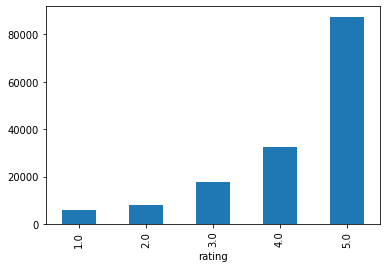

In [20]:
df.groupby('rating').size().plot(kind="bar");
df['rating'].describe()
#histogram of ratings

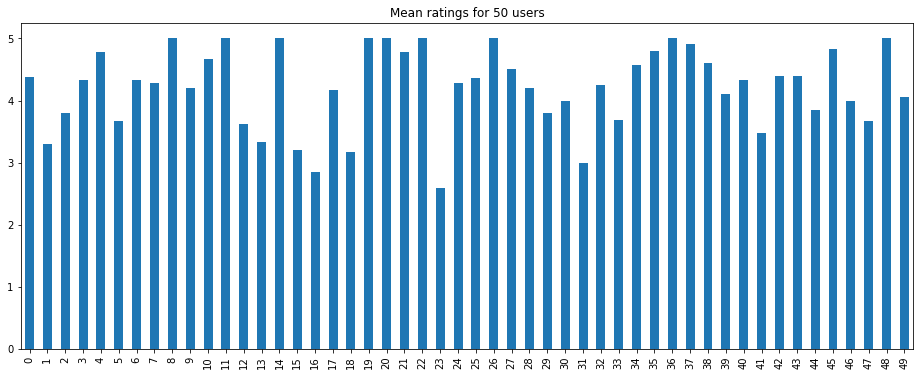

In [21]:
user_means=user_df.rating.apply(lambda x: np.mean(x))
user_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 users");

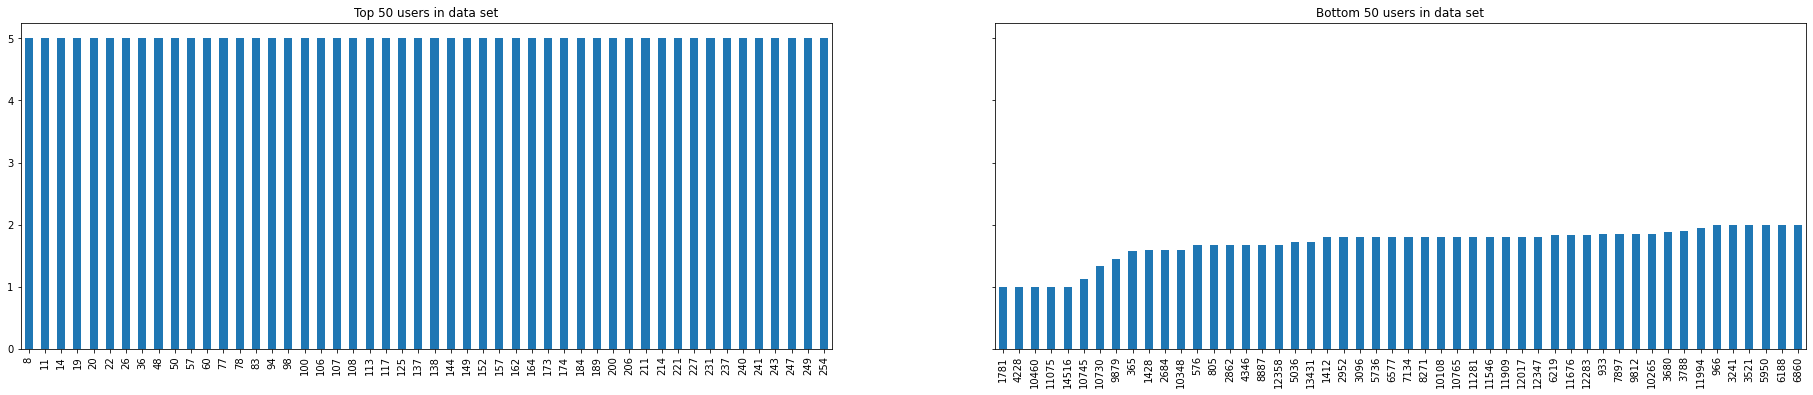

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,6), sharey=True)
user_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 users in data set")
user_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 users in data set");

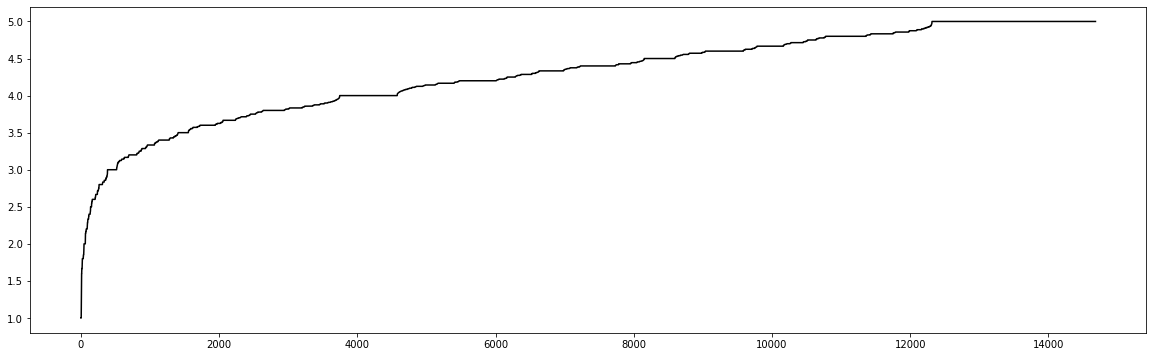

In [23]:
user_means = df.groupby("userID").rating.mean().sort_values()
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(np.arange(len(user_means)), user_means.values, "k-")


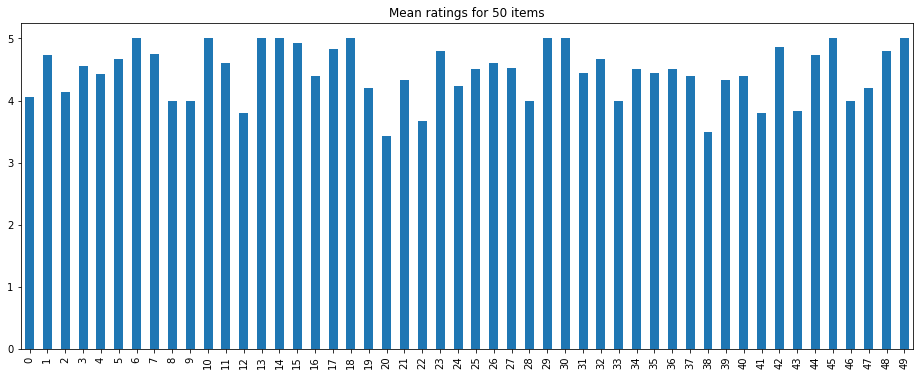

In [24]:
item_means=item_df.rating.apply(lambda x: np.mean(x))
item_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 items");

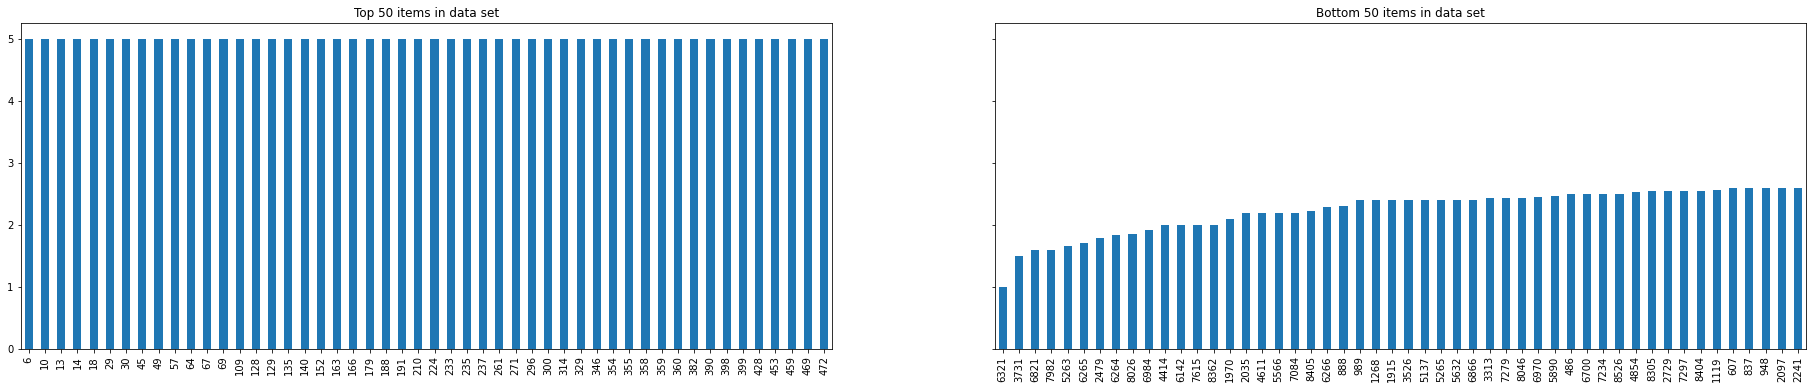

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,6), sharey=True)
item_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 items in data set")
item_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 items in data set");

## Reviews

In [26]:
df['reviewText'].describe()

count     151254
unique    151199
top             
freq          22
Name: reviewText, dtype: object

count    151254.000000
mean        509.002142
std         524.745639
min           0.000000
25%         191.000000
50%         353.000000
75%         644.000000
max       29569.000000
Name: reviewText, dtype: float64

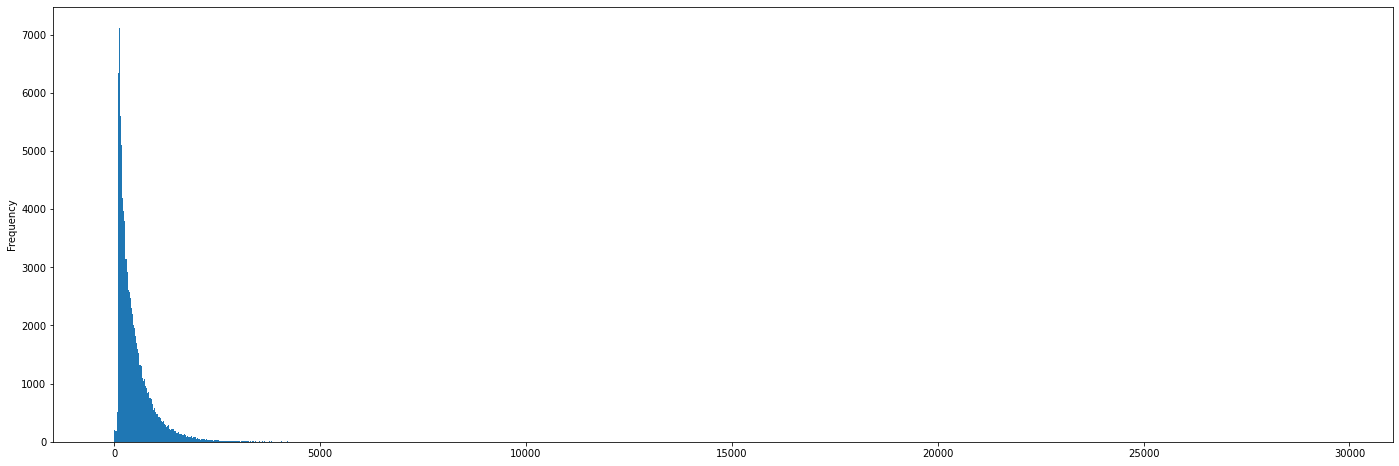

In [27]:
# review length
rv_le=df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()


In [28]:
sum=0
sum2=0
for x in user_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(user_df['reviewText'])
w_mean=sum2/(r_mean*len(user_df['reviewText']))
print('mean of reviews per user:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per user:',r_mean * w_mean)
# plot for reviews per user

mean of reviews per user: 10.302704175464887
mean of words per review: 509.00214209211
mean of words per user: 5244.098494652953


In [29]:
sum=0
sum2=0
for x in item_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(item_df['reviewText'])
w_mean=sum2/(r_mean*len(item_df['reviewText']))
print('mean of reviews per item:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per item:',r_mean * w_mean)

mean of reviews per item: 17.359577642603007
mean of words per review: 509.00214209211
mean of words per item: 8836.062205899232


# **Word Embedding Model**

pretraining by word2vec

In [30]:
# hyperparameters
embedding_dim=300
min_frequent_word_num=50

In [31]:
data = []

In [32]:

tkn=['','[UNK]','[START]','[END]']
for i in range(min_frequent_word_num):
  data.insert(0,tkn)
# adding start and end token for min_ct times
del tkn

In [33]:
for k in range(len(df['reviewText'])):
  # iterate through each sentence in the file
  for i in sent_tokenize(df['reviewText'].loc[k]):
      temp = []
      # tokenize the sentence into words
     
      for j in word_tokenize(i):
          temp.append(j.lower())
      data.append(temp)
      del temp

In [34]:
data[min_frequent_word_num-1]

['', '[UNK]', '[START]', '[END]']

In [35]:
data

[['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[END]'],
 ['', '[UNK]', '[START]', '[

In [36]:
word2vec_model = Word2Vec(data, min_count = min_frequent_word_num ,size = embedding_dim, window = 5, sg=0,iter=20) 

In [37]:
del data[:]
gc.collect()

21

In [38]:
word2vec_model.wv.vocab

{'': <gensim.models.keyedvectors.Vocab at 0x7f95d90e0b10>,
 '[UNK]': <gensim.models.keyedvectors.Vocab at 0x7f9775f8f450>,
 '[START]': <gensim.models.keyedvectors.Vocab at 0x7f976ffa1bd0>,
 '[END]': <gensim.models.keyedvectors.Vocab at 0x7f976e3651d0>,
 'just': <gensim.models.keyedvectors.Vocab at 0x7f976e365150>,
 'another': <gensim.models.keyedvectors.Vocab at 0x7f9774396b90>,
 'flavor': <gensim.models.keyedvectors.Vocab at 0x7f95d90f7e90>,
 'of': <gensim.models.keyedvectors.Vocab at 0x7f95d90f7dd0>,
 'kit': <gensim.models.keyedvectors.Vocab at 0x7f976e365050>,
 'kat': <gensim.models.keyedvectors.Vocab at 0x7f976e365d50>,
 'but': <gensim.models.keyedvectors.Vocab at 0x7f95d90f79d0>,
 'the': <gensim.models.keyedvectors.Vocab at 0x7f95d90f7b90>,
 'taste': <gensim.models.keyedvectors.Vocab at 0x7f9770f1be50>,
 'is': <gensim.models.keyedvectors.Vocab at 0x7f97743ca310>,
 'unique': <gensim.models.keyedvectors.Vocab at 0x7f95d90e9d50>,
 'and': <gensim.models.keyedvectors.Vocab at 0x7f95d90

In [39]:
word2vec_model.wv.get_vector('[START]')

array([ 2.84130037e-01, -1.16862036e-01,  2.06059605e-01, -9.09086838e-02,
        4.73246843e-01, -1.60479043e-02,  4.53326732e-01,  5.72585166e-01,
       -3.12227219e-01, -8.19308996e-01, -4.54541221e-02, -1.46454781e-01,
       -2.21638575e-01,  5.48866838e-02, -3.88016224e-01,  1.15424737e-01,
        4.17863131e-01,  1.11701220e-01, -3.64604950e-01,  1.38344333e-01,
       -2.18602836e-01, -8.18648562e-02,  3.54893774e-01,  4.69178200e-01,
        1.37412131e-01, -1.79058671e-01, -2.05104530e-01,  1.23326801e-01,
       -1.01967104e-01, -7.86959752e-02,  4.18694496e-01,  4.74877954e-02,
       -2.69563168e-01, -1.30687058e-01,  1.87390387e-01,  3.57426077e-01,
       -4.72293645e-01,  9.16332975e-02,  1.14321392e-02, -3.52257900e-02,
        3.81103873e-01,  2.54647046e-01, -2.24674240e-01,  1.12655960e-01,
       -1.93762407e-01, -3.44368555e-02,  6.65165391e-03,  5.71128726e-01,
       -1.18273020e-01,  2.49601752e-02, -1.12715490e-01,  1.25925943e-01,
        4.05227453e-01, -

# **Text Preprocessing**

In [40]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
    #text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  #text = tf.strings.join(['[START]', text, '[END]'], separator=' ')

  #sos and eos are not used in docs but we need to add them manually in the decoder

  return text

## **Text Vectorization**

conversion of string input to sequences of tokens

In [41]:
# hyperparameters
sequence_length=20
review_max_length=100
max_vocab_size= len(word2vec_model.wv.vocab)
print( "max vocab size: ",max_vocab_size)

max vocab size:  7860


In [42]:
# input text processor is in charge of maping word to id and vice versa
input_text_processor = tf.keras.layers.TextVectorization(  max_tokens=max_vocab_size, standardize = tf_lower_and_split_punct,output_sequence_length=review_max_length )

In [43]:
input_text_processor.set_vocabulary(list(word2vec_model.wv.vocab))

In [44]:
# Here are the first 15 words from the vocabulary:
input_text_processor.get_vocabulary()[:15]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'just',
 'another',
 'flavor',
 'of',
 'kit',
 'kat',
 'but',
 'the',
 'taste',
 'is',
 'unique']

In [45]:
print("vocab size(included sos and eos and unk and space)" ,len(input_text_processor.get_vocabulary()))
# start and end tokens are added

vocab size(included sos and eos and unk and space) 7860


* some example about how to work with input text processor

In [46]:
word2vec_model.wv.vocab.get('blend-ins')

In [47]:
list(word2vec_model.wv.vocab)[24]

'i'

In [48]:
input_text_processor.get_vocabulary().index('[START]')

2

In [49]:
input_text_processor.get_vocabulary()[1240]

'cracked'

In [50]:
user_df['reviewText'][2][1]

"I usually love these Knorr/Lipton Rice & Pasta Sides & thought the Teriyaki would 1 of my top 3 flavors (especially knowing how I love my sweet & savory flavors). Boy, was I wrong (I never know whether or not to put ? marks after this type of questions). I don't know exactly what that gross flavor is (maybe the tamarind?), but these noodles have a really weird aftertaste, in my opinion (& another reviewer's). This will not stop me from trying the rice version of the Teriyaki flavor, but I know to stay away from the noodles. Since I always like putting extra soy sauce & teriyaki sauce on my chow mein noodles, I really thought I would love these Asian ones, but surprisingly not the case."

In [51]:
aa=tf.convert_to_tensor("cracked"  )

In [52]:
input_text_processor(  item_df['reviewText'][0][0]  )

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 11,
       20, 21, 22, 13,  1, 13, 11, 23, 19, 24, 25, 26, 27, 16, 17, 28, 19,
       19, 19, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>

## **Converting Vectors To IDs**

**User Documents**

In [53]:
user_doc=[]
for mydoc in user_df['reviewText']:
   user_doc.append( input_text_processor(  mydoc ))


In [54]:
user_doc[7000]

<tf.Tensor: shape=(5, 100), dtype=int64, numpy=
array([[ 125,  189, 1864,  191,   47,   37,   31, 1585,  126,   57, 1413,
         458,   37,   10,  127, 1598,   19,   24,  323,  122,    1,   15,
         150, 1965,   37,  405,  151,   37,   10,  171,  278, 7170,   16,
         431,    7,  189,  397, 1177,   32,  122,  633,  172,  170,  660,
          37,  172,  170, 1177,   52,   12,   11, 1723,  935,   19,   24,
        2393,  172,  191,   52,  602,  219,   26,  156,   16,   17,   19,
          11, 2559, 3396,  345,   32,   11,  224,    7,   11,  217,   13,
          78,   80,   37,  263,   24,  370, 1919, 3993,  283,    7, 1361,
          24,  128,   22,   19,  125,   55,  125,  172, 7170,  152,   31,
          52],
       [  31, 1407,   13,   57,   11,  360,   37,   10,  127,   11,   23,
          19,  172,  133,  281,   26,  219,   91, 1381,  490,  221,   57,
          50,  410,   11,   23,   19,  298,  172,  235,   26,  263,   37,
        2949,   52,  177, 2343,   19,   31,   13,

**Item Documents**

In [55]:
item_doc=[]
for mydoc in item_df['reviewText']:
   item_doc.append( input_text_processor(  mydoc ))

In [56]:
item_df['reviewText'][0][4]

"I've been looking forward to trying these after hearing about how popular they were in Japan, and among Kit Kat fans as well. I do not recommend ordering these during warm weather, because they can melt and become smushy. I ordered mine right when summer began, and they were a bit mushy so I let them solidify under room temp. Afterwards, I tried some and they tasted fine. I was expecting a stronger green tea or matcha flavor, but it is actually quite subtle. The outer coating was creamy and not overly sugary, which I liked. Overall, I wouldn't say it's insanely good, but definitely a yummy treat."

In [57]:
item_doc[5004]

<tf.Tensor: shape=(12, 100), dtype=int64, numpy=
array([[  11, 1087,    7, ..., 2756,    1,   93],
       [  11,   71, 1308, ...,    7,   71,   37],
       [  31,  329, 1043, ..., 1537,  251,   26],
       ...,
       [  24,   88,  251, ...,    7,  150,    7],
       [  31,   13,   39, ...,    0,    0,    0],
       [ 227,   70,   71, ...,    0,    0,    0]])>

Text(0.5, 1.0, 'Mask')

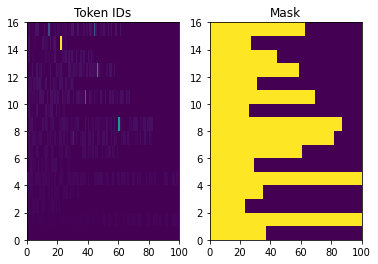

In [58]:
plt.subplot(1, 2, 1)
plt.pcolormesh(item_doc[0])
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(item_doc[0] != 0)
plt.title('Mask')

## **Converting ID to Vector**

In [59]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[user_doc[3282][0].numpy()]
' '.join(tokens)

'just another flavor of kit kat but the taste is unique and a bit different . the only thing that is [UNK] is the price . i thought it was a bit expensive . . . .                                                               '

# **Data Splitting**

In [60]:
dt = np.dtype( [('userid', 'int32'), ('itemid', 'int32'),('rating', 'int32'),('review', 'int32',(sequence_length,) )])


In [61]:
tt=np.empty([150, 1], dtype=dt)

In [62]:
tt['rating'][50][0]

1873834224

In [63]:
current_fold=10
kfold = KFold(10)
random_iterator=kfold.split(df)
for i in range(current_fold):
  train_index, test_index = next(random_iterator, None)
  print(train_index,len(train_index))
  train_df, test_df =df.iloc[train_index], df.iloc[test_index]



train_data=np.empty([train_df.shape[0], ], dtype=dt)
test_data=np.empty([test_df.shape[0], ], dtype=dt)


train_df
user_to_row = {}
item_to_column = {}


for i, user_id in enumerate(np.unique(df['userID'])):
    user_to_row[user_id] = i

for j, item_id in enumerate(np.unique(df['itemID'].tolist())):
    item_to_column[item_id] = j

train_rw=input_text_processor(train_df['reviewText'])[:,:sequence_length]
test_rw=input_text_processor(test_df['reviewText'])[:,:sequence_length]
train_rw
test_rw
for index, row in enumerate( train_df[['userID','itemID','rating']].to_numpy()):
   
    train_data['userid'][index]= user_to_row[row[0]]
    train_data['itemid'][index]= item_to_column[row[1]]
    train_data['rating'][index]= row[2]
    train_data['review'][index]=train_rw[index]
for index, row in enumerate( test_df[['userID','itemID','rating']].to_numpy()):
   
    test_data['userid'][index]= user_to_row[row[0]]
    test_data['itemid'][index]= item_to_column[row[1]]
    test_data['rating'][index]= row[2]
    test_data['review'][index]=train_rw[index]

#for index,row in enumerate( train_data):
 # train_data['review'][row]=train_rw[i]
#for i,row in enumerate( test_data):
#  test_data['review'][row]=train_rw[i]
train_data
test_df[['userID','itemID','rating']].to_numpy()

[ 15126  15127  15128 ... 151251 151252 151253] 136128
[     0      1      2 ... 151251 151252 151253] 136128
[     0      1      2 ... 151251 151252 151253] 136128
[     0      1      2 ... 151251 151252 151253] 136128
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 151251 151252 151253] 136129
[     0      1      2 ... 136126 136127 136128] 136129


array([['A1U6M8VJHK2ECA', 'B009M516NE', 5.0],
       ['A244CRJ2QSVLZ4', 'B009M516NE', 5.0],
       ['A1SB9BNNGKNX2Z', 'B009M516NE', 3.0],
       ...,
       ['ASEBX8TBYWQWA', 'B00KCJRVO2', 5.0],
       ['ANKQGTXHREOI5', 'B00KCJRVO2', 4.0],
       ['A2CF66KIQ3RKX3', 'B00KCJRVO2', 4.0]], dtype=object)

In [64]:
train_rw[50]

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([  24, 1537,  544,   50,   11, 1048, 1049,    7,   31,   71,   37,
         10,   11,    6,   13, 1050, 1051,   19,   24,  251])>

In [65]:
train_data.shape[0]

136129

In [66]:
train_data

array([( 3282,    0, 4, [   4,    5,    6,    7,    8,    9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   11,   20,   21,   22]),
       (  527,    0, 3, [  24,   30,   31,   32,   33,   15,   26,   34,   35,   36,   37,   38,    1,   39,   40,   37,   41,   42,   43,    1]),
       ( 4633,    0, 4, [  88,   80,   19,   89,   90,   57,   91,   92,    7,   70,   71,   93,    4,   45,   28,   52,   94,   95,   35,   96]),
       ...,
       ( 2007, 8080, 3, [  24,  333,   16,   44,    7, 7630, 2223,   52,   31,  325,   52,  109,   16,   58, 3794,  288,  335,  499,   19,  189]),
       ( 6573, 8080, 4, [  24,  106,   82,   52, 4145,   22,  747, 7653,   77,   89,   19,   11, 1921,  170,   78,   80,   19,   39, 3221,  507]),
       (13981, 8080, 3, [  31,   27,   16,  195, 1432,    7,  426,   37,  427,   15, 1017,   19,   26,   98,   16, 5691, 6686,   15,   11,    6])],
      dtype=[('userid', '<i4'), ('itemid', '<i4'), ('rating', '<i4'), ('review', '<i4', (20,))])

In [67]:
train_data[['userid','itemid','rating']]

array([( 3282,    0, 4), (  527,    0, 3), ( 4633,    0, 4), ...,
       ( 2007, 8080, 3), ( 6573, 8080, 4), (13981, 8080, 3)],
      dtype={'names':['userid','itemid','rating'], 'formats':['<i4','<i4','<i4'], 'offsets':[0,4,8], 'itemsize':92})

# **Context-aware Matrix Factorization for Rating Prediction**

In [68]:
#hyperparameters
num_users=user_df.shape[0]
num_items=item_df.shape[0]
feature_num=16


In [69]:
user_specific_vector = tf.Variable(np.zeros(shape=(num_users, feature_num),dtype=np.float32)) 
item_specific_vector = tf.Variable(np.zeros(shape=(num_items, feature_num),dtype=np.float32)) 

## **PMF (Probabilistic Matrix Factorization)**

In [70]:
class PMF():
    def __init__(self, num_feat=16, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=152, batch_size=1000,num_item=9000,num_user=15000,mean_inv=3):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.num_item=num_item
        self.num_user=num_user
        self.V =  0.1 * np.random.randn(self.num_item, self.num_feat).astype(np.float64)  # Item feature vectors
        self.U =  0.1 * np.random.randn(self.num_user, self.num_feat).astype(np.float64)  # User feature vectors
        self.V_inc = np.zeros((self.num_item, self.num_feat),dtype=np.float64)
        self.U_inc = np.zeros((self.num_user, self.num_feat),dtype=np.float64)
        self.rmse_train = []
        self.rmse_test = []
        self.mean_inv= mean_inv  
        
    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    def train(self):
          
            # Shuffle training truples
            shuffled_order = np.arange(train_data.shape[0])  
            np.random.shuffle(shuffled_order)  
            # Batch update
            
            for batch in range(self.num_batches):  
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
              
                batch_idx = np.mod(test, shuffled_order.shape[0])  
            
                batch_UserID = np.array(train_data['userid'][shuffled_order[batch_idx]], dtype='int32')
                batch_ItemID = np.array(train_data['itemid'][shuffled_order[batch_idx]], dtype='int32')
                # Compute Objective Function
               
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                              self.V[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply
                
                rawErr = pred_out - train_data['rating'][shuffled_order[batch_idx]] + self.mean_inv
                
                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.V[batch_ItemID, :]) \
                       + self._lambda * (self.U[batch_UserID, :] - tf.gather(user_specific_vector,batch_UserID).numpy())
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.U[batch_UserID, :]) \
                       + self._lambda * (self.V[batch_ItemID, :] -  tf.gather(item_specific_vector,batch_ItemID).numpy()) 
                       # np.newaxis :increase the dimension
               
                dw_Item = np.zeros((self.num_item, self.num_feat))
                dw_User = np.zeros((self.num_user, self.num_feat))
                
                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
              
                self.V_inc = self.momentum * self.V_inc + self.epsilon * dw_Item / self.batch_size
                self.U_inc = self.momentum * self.U_inc + self.epsilon * dw_User / self.batch_size
                
                self.V = self.V - self.V_inc
                self.U = self.U - self.U_inc
            
                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.U[np.array(train_data['userid'], dtype='int32'), :],
                                                  self.V[np.array(train_data['itemid'], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - train_data['rating'] + self.mean_inv
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.U - user_specific_vector) ** 2 + np.linalg.norm(self.V - item_specific_vector) ** 2)
                   # print("1***************\n",self.U.shape)
                   # print("2***************\n",user_specific_vector.shape)
                    self.rmse_train.append(np.sqrt(obj / train_data.shape[0]))

                # Compute validation error
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.U[np.array(test_data['userid'], dtype='int32'), :],
                                                  self.V[np.array(test_data['itemid'], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - test_data['rating'] + self.mean_inv
                   
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(test_data.shape[0]))

                    # Print info
                    if batch == self.num_batches - 1:
                        print('\nTraining RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))

    def predict(self, invID):
        return np.dot(self.V, self.U[int(invID), :]) + self.mean_inv  # numpy.dot 点乘

    # ****************Set parameters by providing a parameter dictionary.  ***********#

    def topK(self, test_data, k=10):
        inv_lst = np.unique(test_data[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]  # numpy.argsort

        intersection_cnt = {}
        for i in range(test_data.shape[0]):
            if test_data[i, 1] in pred[test_data[i, 0]]:
                intersection_cnt[test_data[i, 0]] = intersection_cnt.get(test_data[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_data[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)


# **Adversarial Seq2Seq Learning**

## **Metrics**

In [71]:
# log files for training and test
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
graph_log_dir = 'logs/graph/' + current_time 
graph_summary_writer = tf.summary.create_file_writer(graph_log_dir)

In [72]:
class PerplexityMetric(tf.keras.metrics.Metric):
    def __init__(self,name='perplexity',**kwargs):
        super().__init__(name=name, **kwargs)
        self.perplexity=self.add_weight(name='pl',initializer='zeros')

    def update_state(self, nll_loss):
        self.perplexity= 2 ** nll_loss

    def result(self):
        return self.perplexity

In [73]:
train_plx_gen_tch = PerplexityMetric(name='generator perplexity')  # teacher forcing mode
train_plx_gen_plc = PerplexityMetric(name='generator perplexity')  # policy gradient mode
train_loss_gen_policy = tf.keras.metrics.Mean('train loss gen policy', dtype=tf.float32)

train_acc_dis = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

## **Recurrent Review Generator**

- it consists of two encoders and one decoder

### **Encoder**

In [74]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, embedding_dim, enc_units):
    super().__init__()
    self.enc_units = enc_units
    self.input_vocab_size = max_vocab_size
    self.embedding = tf.keras.layers.Embedding(max_vocab_size, embedding_dim, embeddings_initializer=keras.initializers.Constant(word2vec_model.wv.vectors),trainable=False)
    self.gru= tf.keras.layers.Bidirectional(tf.keras.layers.GRU(enc_units,return_state=True,  recurrent_initializer='glorot_uniform' ))


  def call(self, reviews, state=None):
   
    vectors = self.embedding(reviews)
    _,encoder_forward_state,encoder_backward_state  = self.gru(vectors, initial_state=state)
 
    return  tf.concat([ encoder_forward_state, encoder_backward_state],-1)

    

### **Decoder (Generator)**

In [75]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, embedding_dim, dec_units):
    super().__init__()
    self.dec_units = dec_units
    self.output_vocab_size = max_vocab_size
    self.embedding = tf.keras.layers.Embedding(max_vocab_size, embedding_dim,embeddings_initializer=keras.initializers.Constant(word2vec_model.wv.vectors), trainable=False)
    self.gru=tf.keras.layers.GRU(dec_units , return_state=True,return_sequences=True)
    self.fc = tf.keras.layers.Dense(max_vocab_size, use_bias=False)
    self.sf=tf.keras.layers.Activation('softmax')

  def call(self, decoder_input, context_vector,state=None):

     embedded_input= self.embedding(decoder_input)
     joint_input_context =tf.concat([embedded_input, tf.tile(tf.expand_dims(context_vector,1),[1,embedded_input.shape[1],1])],2 )
     outputs,dec_state =self.gru(joint_input_context, initial_state=state)
     logits = self.fc( outputs)
     prob_dist=self.sf(logits)

     return prob_dist,dec_state

  

In [76]:
class GeneratorLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
   # self.loss = tf.keras.losses.SparseCategoricalCrossentropy( reduction='none')

  def __call__(self, y_true, y_pred):
    # Calculating the loss for a batch of reviews.

    mask = tf.cast(y_true != 0, tf.int32)
    maskoff_ind=tf.reduce_sum(mask)
    a=tf.one_hot(y_true[:maskoff_ind], max_vocab_size, 1.0, 0.0)
    b=tf.math.log( tf.clip_by_value(y_pred[:maskoff_ind], 1e-20, 1.0))
    #print(y_true)
    #print("\n\n\n",a)
    #print("\n\n\n",b)
    c=a * b
   # print("\n\n\n",c)
    loss=-tf.reduce_sum(c) /tf.cast(maskoff_ind,dtype=tf.float32)
   # print(loss)
    return loss

## **Discriminator**

In [77]:
class Discriminator(tf.keras.Model):
    def __init__( self, sequence_length, vocab_size, embedding_dim, filter_sizes, num_filters, l2_reg_lambda=0.0):
      super().__init__()
      self.sequence_length=sequence_length
      self.vocab_size=max_vocab_size
      self.embedding_dim=embedding_dim
      self.filter_sizes=filter_sizes
      self.num_filters= num_filters

      self.embedding = tf.keras.layers.Embedding(max_vocab_size, embedding_dim,weights=[word2vec_model.wv.vectors],name="discriminator_embedding",trainable=False)
     
      self.conv_unigram= tf.keras.layers.Conv1D(num_filters, filter_sizes[0], activation="tanh",name="conv_unigram")
      self.conv_bigram= tf.keras.layers.Conv1D(num_filters, filter_sizes[1],activation="tanh",name="conv_bigram")
      self.conv_trigram= tf.keras.layers.Conv1D(num_filters, filter_sizes[2],activation="tanh",name="conv_trigram")
      self.conv_fourgram= tf.keras.layers.Conv1D(num_filters, filter_sizes[3],activation="tanh",name="conv_fourgram")
      self.conv_fivegram= tf.keras.layers.Conv1D(num_filters, filter_sizes[4],activation="tanh",name="conv_fivegram")

      self.gmp_unigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_unigram")
      self.gmp_bigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_bigram")
      self.gmp_trigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_trigram")
      self.gmp_fourgram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_fourgram")
      self.gmp_fivegram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_fivegram")

      self.dropout=tf.keras.layers.Dropout(.5,name="dropout")
      self.fc=tf.keras.layers.Dense(1,activation="sigmoid")


    def get_reward(self, discriminator_inputs , context_vector ):
      
      embedded_input= self.embedding(discriminator_inputs)
      # print("\n\n embeded",embeded_input.shape)
      joint_input_context =tf.concat([embedded_input, tf.tile(tf.expand_dims(context_vector,1),[1,embedded_input.shape[1],1])],2 )

      #  print("\n\n joint:",joint_input_context.shape)
      # print(new_vector.shape)
      #new_vector=tf.reshape(new_vector,[new_vector.shape[1],new_vector.shape[2],1])
      #print(new_vector[0])
      # joint_input_context_reshaped=tf.transpose( joint_input_context,perm=[0,2,1])
      #print("\n\n joint reshaped:",joint_input_context_reshaped.shape)

      cv_unigram=self.conv_unigram(joint_input_context)
      cv_bigram=self.conv_bigram(joint_input_context)
      cv_trigram=self.conv_trigram(joint_input_context)
      cv_fourgram=self.conv_fourgram(joint_input_context)
      cv_fivegram=self.conv_fivegram(joint_input_context)

      #print(" cv uni: ",cv_unigram.shape)
      #print(" cv bi: ",cv_bigram.shape)
      #print(" cv tri: ",cv_trigram.shape)
      #print(" cv four: ",cv_fourgram.shape)
      #print(" cv five: ",cv_fivegram.shape)

      #cv_unigram = tf.reshape(cv_unigram,(cv_unigram.shape[1] , cv_unigram.shape[2], 1))
     
      gmp_unigram = self.gmp_unigram(cv_unigram)
     # cv_bigram = tf.reshape(cv_bigram,(cv_bigram.shape[1] , cv_bigram.shape[2], 1))
      gmp_bigram = self.gmp_bigram(cv_bigram)
     # cv_trigram = tf.reshape(cv_trigram,(cv_trigram.shape[1] , cv_trigram.shape[2], 1))
      gmp_trigram =  self.gmp_trigram(cv_trigram)
     # cv_fourgram = tf.reshape(cv_fourgram,(cv_fourgram.shape[1] , cv_fourgram.shape[2], 1))
      gmp_fourgram = self.gmp_fourgram(cv_fourgram)
     # cv_fivegram = tf.reshape(cv_fivegram,(cv_fivegram.shape[1] , cv_fivegram.shape[2], 1))
      gmp_fivegram = self.gmp_fivegram(cv_fivegram)

     # print(gmp_unigram)
      #print(gmp_bigram)
      #print(gmp_trigram)
     # print(gmp_fourgram)
     # print(gmp_fivegram)
      gmp_overal= tf.concat([gmp_unigram,gmp_bigram,gmp_trigram,gmp_fourgram,gmp_fivegram],1)
      #print("gmp :",gmp_overal)
      #training=true must be studied more but i know dropout during test must not be working
      dropout = self.dropout(gmp_overal,training=True)
     # print(dropout)
      ath= self.fc(dropout)
      gc.collect()
     # print(ath)
      return ath[:,0]


In [78]:
class DiscriminatorLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'cross-entropy_loss'
    self.binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy( reduction='none')

  def __call__(self, y_true, y_pred):
    loss = self.binary_cross_entropy_loss(y_true, y_pred)
    return loss

## **Adversarial Training**

In [79]:
#hyperparameter
t_step=1 # teacher forcing training number
g_step=1 # generator training number
d_step=3 # discriminator training number
rollout_num=1
units=int(feature_num/2 )# gru units
batch_size=4
num_batches=int(train_data.shape[0]/batch_size)

In [80]:
class MaskedLossReward(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss_reward'

  def __call__(self, y_true, y_pred,reward):
    # Calculate the loss for each step.

    mask = tf.cast(y_true != 0, tf.int32)
    maskoff_ind=tf.reduce_sum(mask)
    a=tf.one_hot(y_true[:maskoff_ind], max_vocab_size, 1.0, 0.0)
    b=tf.math.log( tf.clip_by_value(y_pred[:maskoff_ind], 1e-20, 1.0))
    aa=tf.reduce_sum( a * b,2)

    aaa=aa*reward[:maskoff_ind]
    loss=- tf.reduce_sum(aaa)  /tf.cast(maskoff_ind,dtype=tf.float32)
    return loss

In [81]:
class Seq2Seq(tf.keras.Model): 
    def __init__(self, latent_dim, num_batches, batch_size, use_tf_function=False):
        super().__init__()
        self.use_tf_function = use_tf_function
        self.num_batches=num_batches
        self.batch_size=batch_size
        self.latent_dim = latent_dim

        self.user_encoder = Encoder(embedding_dim, units)
        self.item_encoder = Encoder(embedding_dim, units)
        self.decoder = Decoder(embedding_dim, units) #generator
        self.discriminator = Discriminator(sequence_length, max_vocab_size, embedding_dim,[1, 2, 3 ,4, 5] ,100)
      
        self.loss_gn=GeneratorLoss()
        self.loss_ds=DiscriminatorLoss()
        self.loss_fn = MaskedLossReward() # generator loss with reward

        self.optimizer_gn=tf.optimizers.Adam()
        self.optimizer_ds=tf.optimizers.Adam()


        dec_pred=tf.zeros([batch_size,sequence_length+1,max_vocab_size],dtype= tf.float32)

    # def _train_step_gn_teacher(self, batch_UserID, batch_ItemID,batch_review):

    #     with tf.GradientTape() as tape:

    #       batch_Userdoc=[user_doc[i] for i in batch_UserID]
    #       batch_Itemdoc=[item_doc[i] for i in batch_ItemID]
    #       user_review_num=np.sum([it.shape[0] for it in batch_Userdoc],dtype=int)
    #       item_review_num=np.sum([it.shape[0] for it in batch_Itemdoc],dtype=int)

    #       batch_Userdoc_flattened= []
    #       for i, doc in enumerate(batch_Userdoc):
    #           batch_Userdoc_flattened=np.append(batch_Userdoc_flattened, doc)

    #       batch_Itemdoc_flattened= []
    #       for i, doc in enumerate(batch_Itemdoc):
    #           batch_Itemdoc_flattened=np.append(batch_Itemdoc_flattened, doc)
  
    #       user_enc_state = self.user_encoder(tf.reshape( tf.convert_to_tensor(batch_Userdoc_flattened,dtype=tf.int32) ,[user_review_num,review_max_length])) # user vector representations      
    #       item_enc_state = self.item_encoder(tf.reshape( tf.convert_to_tensor(batch_Itemdoc_flattened,dtype=tf.int32) ,[item_review_num,review_max_length])) # item vector representations
              
    #       pointer=0
    #       user_context_vector=tf.zeros([0,feature_num])
        
    #       for i,doc in enumerate(batch_Userdoc): 
    #         user_context_vector=tf.concat([ user_context_vector, tf.reduce_mean(user_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
    #         pointer +=doc.shape[0]
    
    #       pointer=0
    #       item_context_vector=tf.zeros([0,feature_num])
          
    #       for i,doc in enumerate(batch_Itemdoc): 
    #         item_context_vector=tf.concat([ item_context_vector, tf.reduce_mean(item_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
    #         pointer +=doc.shape[0]

    #       context_vector= tf.concat( [user_context_vector,item_context_vector],1)
    
    #       loss = tf.constant(0.0)
    #       dec_pred, dec_state=self.decoder(tf.concat([np.transpose([[2] * batch_size]), batch_review],1) , context_vector)
          
    #       loss=self.loss_gn(tf.concat([batch_review , np.transpose([[3] * batch_size]) ],1),  dec_pred)
    #     variables =self.user_encoder.trainable_variables + self.item_encoder.trainable_variables + self.decoder.trainable_variables
    #     gradients = tape.gradient(loss,variables)
    #     print(loss)
    #     self.optimizer_gn.apply_gradients(zip(gradients, variables))          
    #     print("gen batch loss in supervised training", loss.numpy())
    #       # returning the probablity distribution over words for a batch of reviews

    # def _train_step_gn_policy(self, batch_UserID, batch_ItemID):

    #     #generating a batch of reviews
    #     generated_samples,context_vector= self.generate_sample(batch_UserID,batch_ItemID)
    #     generated_samples=tf.cast( tf.concat([np.transpose([[2] * batch_size]), generated_samples,np.transpose([[3] * batch_size])],1), dtype=tf.float32 )
    #     reward=[]
    #     g_loss = tf.constant(0.0) 

    #     with tf.GradientTape() as tape:
                
    #             for k in range(rollout_num):
                   
    #                 for given_num in range(1,sequence_length+2):
    #                   # the generation of first part of seq
    #                   joint_dec_inputs_context=self.decoder.concat_input_context(generated_samples[:,:given_num], context_vector) 
    #                   _, dec_state=self.decoder(joint_dec_inputs_context)

    #                   # generated probability distribution given the samples
    #                   dec_rollout_prob=tf.zeros([batch_size,1,max_vocab_size],dtype= tf.float32)                     
    #                   rollout_samples=tf.zeros([sequence_length-given_num+1, batch_size] ,dtype= tf.float32)                 
    #                   rd=None
    #                   gc.collect()

    #                   if given_num!=sequence_length+2:
    #                       # sampling seq length - i tokens with the roll out policy 
                        
    #                       current_input_token=tf.Variable(generated_samples[:,given_num-1:given_num])
    #                       print("type new_tokens :",type(current_input_token))
    #                       rollout_samples_list =tf.unstack(rollout_samples)                   
    #                       for j in range(sequence_length-given_num+2):
    #                           joint_dec_inputs_context=self.decoder.concat_input_context(current_input_token, context_vector )
    #                           dec_rollout_prob,dec_state=self.decoder( joint_dec_inputs_context ,dec_state)
                           
    #                           # Sample a token
    #                           current_input_token =tf.Variable( tf.random.categorical(dec_rollout_prob[:,0,:],1,dtype=tf.int32) ) 

    #                           rollout_samples_list.append(tf.cast( current_input_token[:,0],tf.float32))
                      
    #                       rollout_samples=tf.stack(tf.transpose(rollout_samples_list))   

     
    #                       full_samples= tf.concat([ generated_samples[:,1:given_num], rollout_samples] ,1)
    #                       dec_rollout_prob=None
    #                       rollout_samples=None                        
    #                       gc.collect()
    #                       gc.collect(0)   
    #                       gc.collect(1)   
    #                       gc.collect(2)   

    #                       #full sample
    #                       rd=self.discriminator.get_reward(full_samples,context_vector)

    #                   else:
    #                       rd=self.discriminator.get_reward(generated_samples[:,1:],context_vector)
    #                       #  print("size of dis",asizeof.asized(self.discriminator, detail=1).format() )

                    
    #                   if k==0: 
    #                       reward.append(rd)
    #                   else:
    #                      reward[given_num-1] +=rd  


    #             reward= tf.stack(reward,1)/ rollout_num # batchsize * seq_length
    #             g_loss= self.loss_fn(generated_samples[:,1:] , self.gn_pred_prob , reward)
    #             print("gen batch loss in policy gradient training: ",g_loss.numpy())

    #             variables = self.decoder.trainable_variables 
    #             gradients = tape.gradient(g_loss, variables)
                
    #             print("\n\n", gradients)
    #             self.optimizer_gn.apply_gradients(zip(gradients, variables))

    def _train_step_disc(self):

          with tf.GradientTape() as tape:

            positive_data,positive_user_indices,positive_item_indices = self.sample_real_data() # ground-truth data
            negative_data,negative_user_indices,negative_item_indices = self.sample_fake_data() # machine-generated data
            #data shape (batch_size * seq length)
            whole_user_indices=tf.concat([positive_user_indices,negative_user_indices],0)
            whole_item_indices= tf.concat([positive_item_indices,negative_item_indices],0)

            positive_labels = tf.ones(batch_size, dtype=tf.int32) 
            negative_labels = tf.zeros(batch_size, dtype=tf.int32) 
            labels = tf.concat([positive_labels, negative_labels], 0)

            shuffle_indices = tf.random.shuffle( tf.range(0, len(labels),dtype=tf.int32))
            whole_data = tf.gather(tf.concat([positive_data,negative_data],0),shuffle_indices)    
            labels = tf.gather(labels,shuffle_indices)
            whole_user_indices = tf.gather(whole_user_indices,shuffle_indices)
            whole_item_indices = tf.gather(whole_item_indices,shuffle_indices)
            query_embedding = tf.concat([tf.gather(user_specific_vector , whole_user_indices) ,tf.gather( item_specific_vector , whole_item_indices)], 1)
            # query shape (batch_size ,2.feature_num)
            dis_reward = self.discriminator.get_reward( whole_data,query_embedding)

            #for i in range(real_data_num+fake_data_num):
              #print(tf.convert_to_tensor( whole_data[i]))
              #print(whole_user_indices[i])
              # print(user_specific_vector[whole_user_indices[i] ])
              #reward.append([0][0].numpy() )
            #print(reward)
            disc_loss=self.loss_ds(labels,dis_reward)
          variables = self.discriminator.trainable_variables 
          # print(variables)
          gradients = tape.gradient(disc_loss, variables)
          # print("************************* gradient :",gradients)
          self.optimizer_ds.apply_gradients(zip(gradients, variables))
          #calculate loss and gradient
          print("disc loss: ",disc_loss)

          train_acc_dis.update_state(labels,dis_reward)

    def sample_real_data(self):

      sample = train_data[np.random.choice(range(0,train_data.shape[0]),batch_size)][['userid','itemid','review']]

      return   tf.stack(sample['review']) ,sample['userid'], sample['itemid']
 
    def sample_fake_data(self):
                

      drawn_userid = np.random.choice(range(0,num_users),batch_size).astype('int32')
      drawn_itemid = np.random.choice(range(0,num_items),batch_size).astype('int32')    
      sample,_= self.generate_sample(drawn_userid,drawn_itemid)

      return sample,drawn_userid,drawn_itemid

    def generate_sample(self,batch_UserID, batch_ItemID):
        
        batch_Userdoc=[user_doc[i] for i in batch_UserID]
        batch_Itemdoc=[item_doc[i] for i in batch_ItemID]
        user_review_num=np.sum([it.shape[0] for it in batch_Userdoc])
        item_review_num=np.sum([it.shape[0] for it in batch_Itemdoc])
        batch_Userdoc_flattened= []
        for i, doc in enumerate(batch_Userdoc):
            batch_Userdoc_flattened=np.append(batch_Userdoc_flattened, doc)
        batch_Itemdoc_flattened= []
        for i, doc in enumerate(batch_Itemdoc):
            batch_Itemdoc_flattened=np.append(batch_Itemdoc_flattened, doc)
        user_enc_state = self.user_encoder(tf.reshape(batch_Userdoc_flattened.astype(int),[user_review_num,review_max_length])) # user vector representations      
        item_enc_state = self.item_encoder(tf.reshape(batch_Itemdoc_flattened.astype(int),[item_review_num,review_max_length])) # item vector representations
      
        pointer=0
        user_context_vector=tf.zeros([0,feature_num])

        for i,doc in enumerate(batch_Userdoc): 
          user_context_vector=tf.concat([ user_context_vector, tf.reduce_mean(user_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
          pointer +=doc.shape[0]
    
        pointer=0
        item_context_vector=tf.zeros([0,feature_num])

        for i,doc in enumerate(batch_Itemdoc): 
          item_context_vector=tf.concat([ item_context_vector, tf.reduce_mean(item_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
          pointer +=doc.shape[0]

        context_vector= tf.concat( [user_context_vector,item_context_vector],1)
        
        dec_state=None
        dec_prob=[]
        dec_out=tf.constant(np.full((len(batch_Itemdoc),1),2),dtype=tf.int32)
            
        for j in range(sequence_length):           
            dec_prob,dec_state=self.decoder( dec_out[:,j:j+1], context_vector ,dec_state)
            #probability distribution of words  
            # Sample a token from the last distribution
            new_tokens =tf.random.categorical(dec_prob[:,-1],1,dtype=tf.int32)    
            dec_out= tf.concat([dec_out, new_tokens],-1)   
        
            del dec_prob          
            del new_tokens 

        gc.collect()  
        return dec_out[:,1:],context_vector

    # def generate_incompleted_sample(self, context_vector,partial_sample):
    #   #given a partial sequence as an input for decoder, this function generate a seq with particular length as an output
      
    #     joint_dec_inputs_context=self.decoder.concat_input_context(partial_sample, context_vector) 
      
    #     dec_result, dec_state=self.decoder(joint_dec_inputs_context)
    #     gc.collect()
    #     #print("incomplete",tracemalloc.get_traced_memory())

    #     return dec_result,dec_state

    # def rollout(self,dec_st,context_vector, initial_token,initial_index):
    #     dec_state=dec_st
    #     dec_pr=np.zeros([sequence_length-initial_index,self.batch_size,1,max_vocab_size],dtype= np.float32)
    #     dec_out=initial_token
    #     joint_dec_inputs_context=None
    #     new_tokens=None
    #     for j in range(sequence_length-initial_index):


    #         joint_dec_inputs_context=self.decoder.concat_input_context(dec_out[:,-1:], context_vector )


    #         dec_pr[j],dec_state=self.decoder( joint_dec_inputs_context ,dec_state)
            
    #         #probability distribution of words  
    #         # Sample a token
    #         new_tokens =tf.random.categorical(dec_pr[j,:,0],1,dtype=tf.int32)  
    #         #print('120', psutil.virtual_memory()[2])
    #         dec_out= tf.concat([dec_out, new_tokens],-1)  
    #         #print('123', psutil.virtual_memory()[2])
          
    #         joint_dec_inputs_context=None
            
    #         gc.collect()


    #     self.dec_prob=tf.transpose(dec_pr,[2,1,0,3])[0]
    #     dec_pr=None 
    #     gc.collect()
      
    #     print('roll out end', psutil.virtual_memory()[2])

    #     #print(dec_out)
    #     # print("\n\n\n",dec_prob)
    #     return dec_out[:,1:]
    def train(self,batch_Userdoc,batch_Itemdoc,batch_review,batch_Userdoc_flattened,batch_Itemdoc_flattened,user_review_num,item_review_num):

            # t step generator training teacher forcing
            for i in range(t_step): 
              with tf.device('/CPU:0'):
               #self._train_step_gn_teacher(batch_UserID,batch_ItemID,batch_review)
                with tf.GradientTape() as tape:
      
                  user_enc_state = self.user_encoder(tf.reshape( tf.convert_to_tensor(batch_Userdoc_flattened,dtype=tf.int32) ,[user_review_num,review_max_length])) # user vector representations      
                  item_enc_state = self.item_encoder(tf.reshape( tf.convert_to_tensor(batch_Itemdoc_flattened,dtype=tf.int32) ,[item_review_num,review_max_length])) # item vector representations
                      
                  pointer=0
                  user_context_vector=tf.zeros([0,feature_num])
                
                  for i,doc in enumerate(batch_Userdoc): 
                    user_context_vector=tf.concat([ user_context_vector, tf.reduce_mean(user_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
                    pointer +=doc.shape[0]
            
                  pointer=0
                  item_context_vector=tf.zeros([0,feature_num])
                  
                  for i,doc in enumerate(batch_Itemdoc): 
                    item_context_vector=tf.concat([ item_context_vector, tf.reduce_mean(item_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
                    pointer +=doc.shape[0]

                  context_vector= tf.concat( [user_context_vector,item_context_vector],1)
            
                  loss = tf.constant(0.0)
                  dec_pred, dec_state=self.decoder(tf.concat([tf.cast( np.transpose([[2] * batch_size]),dtype=tf.int32 ), batch_review],1) , context_vector)
                  
                  loss=self.loss_gn(tf.concat([batch_review ,tf.cast( np.transpose([[3] * batch_size]),dtype=tf.int32) ],1),  dec_pred)
                variables =self.user_encoder.trainable_variables + self.item_encoder.trainable_variables + self.decoder.trainable_variables
                gradients = tape.gradient(loss,variables)
                self.optimizer_gn.apply_gradients(zip(gradients, variables))          
                print("gen batch loss in supervised training", loss)
                
                train_plx_gen_tch.update_state(loss)
 
            # g step generator training policy gradient    
            for it in range(g_step):             
                #self._train_step_gn_policy(batch_UserID,batch_ItemID)  
              with tf.device('/CPU:0'):

                with tf.GradientTape() as tape:
                  user_enc_state = self.user_encoder(tf.reshape( tf.convert_to_tensor(batch_Userdoc_flattened,dtype=tf.int32) ,[user_review_num,review_max_length])) # user vector representations      
                  item_enc_state = self.item_encoder(tf.reshape( tf.convert_to_tensor(batch_Itemdoc_flattened,dtype=tf.int32) ,[item_review_num,review_max_length])) # item vector representations                   
                  pointer=0
                  user_context_vector=tf.zeros([0,feature_num])                
                  for i,doc in enumerate(batch_Userdoc): 
                    user_context_vector=tf.concat([ user_context_vector, tf.reduce_mean(user_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
                    pointer +=doc.shape[0]            
                  pointer=0
                  item_context_vector=tf.zeros([0,feature_num])                  
                  for i,doc in enumerate(batch_Itemdoc): 
                    item_context_vector=tf.concat([ item_context_vector, tf.reduce_mean(item_enc_state[pointer:pointer + doc.shape[0]],0,keepdims=True)   ],0)
                    pointer +=doc.shape[0]
                  context_vector= tf.concat( [user_context_vector,item_context_vector],1)
                 
                  dec_state=None
                  dec_prob=[]
                  generated_samples=tf.cast(tf.constant(np.full((len(batch_Itemdoc),1),2)),dtype=tf.int32)
                      
                  for j in range(sequence_length):                      
                      d_prob,dec_state=self.decoder( generated_samples[:,j:j+1], context_vector ,dec_state)
                      dec_prob.append(d_prob[:,-1])
                      #probability distribution of words  
                      # Sample a token from the last distribution
                      new_tokens =tf.random.categorical(d_prob[:,-1],1,dtype=tf.int32)    
                      generated_samples= tf.concat([generated_samples, new_tokens],-1)   
                      del d_prob          
                                  
                  #generated_samples,context_vector= self.generate_sample(batch_UserID,batch_ItemID)
                  #generated_samples=tf.cast(tf.concat([generated_samples,np.transpose([[3] * batch_size])],1),dtype=tf.int32)
       # generating samples
                  g_loss = tf.constant(0.0)           

                  reward=[]
                  with tape.stop_recording():
                    for k in range(rollout_num):
                      
                        for given_num in range(1,sequence_length+1):
                          # the generation of first part of seq
                          _, dec_state=self.decoder(generated_samples[:,:given_num], context_vector)

                          # generated probability distribution given the samples
                          dec_rollout_prob=tf.zeros([batch_size,1,max_vocab_size],dtype= tf.float32)                     
                          rollout_samples=tf.zeros([sequence_length-given_num+1, batch_size] ,dtype= tf.int32)                 
                          rd=None

                          if given_num!=sequence_length+2:
                              # sampling seq length - i tokens with the roll out policy 
                            
                              current_input_token=generated_samples[:,given_num-1:given_num]
                              rollout_samples_list =tf.unstack(rollout_samples)                   
                              for j in range(sequence_length-given_num+2):
                                  dec_rollout_prob,dec_state=self.decoder( current_input_token, context_vector ,dec_state)
                              
                                  # Sample a token
                                  current_input_token = tf.random.categorical(dec_rollout_prob[:,0,:],1,dtype=tf.int32) 

                                  rollout_samples_list.append(current_input_token[:,0])
                          
                              rollout_samples=tf.stack(tf.transpose(rollout_samples_list))   
                              full_samples= tf.concat([ generated_samples[:,1:given_num], rollout_samples] ,1)
                              dec_rollout_prob=None
                              rollout_samples=None                        
                              gc.collect()
                              gc.collect(0)   
                              gc.collect(1)   
                              gc.collect(2)   

                              #full sample
                              rd=self.discriminator.get_reward(full_samples,context_vector)

                          else:
                              rd=self.discriminator.get_reward(generated_samples[:,1:],context_vector)
                              #  print("size of dis",asizeof.asized(self.discriminator, detail=1).format() )

                        
                          if k==0: 
                              reward.append(rd)
                          else:
                            reward[given_num-1] +=rd  


                  reward= tf.stack(reward,1)/ rollout_num # batchsize * seq_length
                  g_loss= self.loss_fn(generated_samples[:,1:] , tf.transpose( tf.stack(dec_prob) ,[1,0,2]) , reward)
                variables = self.user_encoder.trainable_variables + self.item_encoder.trainable_variables + self.decoder.trainable_variables 
                gradients = tape.gradient(g_loss, variables)                  
                self.optimizer_gn.apply_gradients(zip(gradients, variables))
                print("gen batch loss in policy gradient training: ",g_loss)
                train_plx_gen_plc.update_state(g_loss)
          
            # d step discriminator training
            for it in range(d_step):
                self._train_step_disc()




# **Multi-Task Learning**

In [82]:
class MultiTaskModel(tf.keras.Model):
      def __init__(self):
        super().__init__()
        self.pmf_model=PMF(num_feat=feature_num,maxepoch=100,num_item=len(item_to_column) ,num_user=len(user_to_row), mean_inv=np.mean(train_data['rating']))
        self.seq2seq_model=Seq2Seq(embedding_dim,num_batches,batch_size)      

      def train(self,n_epochs):    
     
          for epoch in range(n_epochs):
            print("\n\nepoch : ",epoch)
            print("********************************************* \nPMF Model Training Turn =>")
            self.pmf_model.train()
            print("********************************************* \nSeq2Seq Model Training Turn =>")             
           
            shuffled_order = np.arange(train_data.shape[0]) 
            np.random.shuffle(shuffled_order) 
    
            for batch in range(4):
              with tf.profiler.experimental.Trace("train",step_num=batch, _r=1):
                print("\nbatch number : ",batch)
                test = np.arange(batch_size * batch, batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])
                batch_UserID = np.array(train_data['userid'][shuffled_order[batch_idx]], dtype=np.int16)
                batch_ItemID = np.array(train_data['itemid'][shuffled_order[batch_idx]], dtype=np.int16)
                batch_review = np.array(train_data['review'][shuffled_order[batch_idx]], dtype=np.int32)

                batch_Userdoc=[user_doc[i] for i in batch_UserID]
                batch_Itemdoc=[item_doc[i] for i in batch_ItemID]
                user_review_num=np.sum([it.shape[0] for it in batch_Userdoc],dtype=int)
                item_review_num=np.sum([it.shape[0] for it in batch_Itemdoc],dtype=int)

                batch_Userdoc_flattened= []
                for i, doc in enumerate(batch_Userdoc):
                    batch_Userdoc_flattened=np.append(batch_Userdoc_flattened, doc)

                batch_Itemdoc_flattened= []
                for i, doc in enumerate(batch_Itemdoc):
                    batch_Itemdoc_flattened=np.append(batch_Itemdoc_flattened, doc)
                #tf.summary.trace_on(graph=True, profiler=True)
                
                z = self.seq2seq_model.train( batch_Userdoc,batch_Itemdoc,batch_review,tf.cast( batch_Userdoc_flattened,dtype=tf.int32) , tf.cast(batch_Itemdoc_flattened , dtype=tf.int32),user_review_num,item_review_num)
           

            # for (x_test, y_test) in test_dataset:
            #       test_step(model, x_test, y_test)

            with train_summary_writer.as_default():
                tf.summary.scalar('Training perplexity for generator in Teacher Forcing mode', train_plx_gen_tch.result(), step=epoch)
                tf.summary.scalar('Training perplexity for generator in Policy Gradient mode', train_plx_gen_plc.result(), step=epoch)
                tf.summary.scalar('Training accuracy for discriminator', train_acc_dis.result(), step=epoch)
          
 
            # with graph_summary_writer.as_default():
            #     tf.summary.trace_export('seq2seq train step',profiler_outdir=graph_log_dir,step=epoch)


In [84]:
gc.collect()
gc.collect(0)
gc.collect(1)
gc.collect(2)

# creating an instance of Multi_Task Model
mt_model = MultiTaskModel()
mt_model.train(n_epochs=3)




epoch :  0
********************************************* 
PMF Model Training Turn =>

Training RMSE: 1.088929, Test RMSE 1.080800
********************************************* 
Seq2Seq Model Training Turn =>

batch number :  0
gen batch loss in supervised training tf.Tensor(8.97257, shape=(), dtype=float32)
gen batch loss in policy gradient training:  tf.Tensor(3.6487648, shape=(), dtype=float32)


2022-11-08 15:46:21.663966: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-11-08 15:46:21.763932: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


disc loss:  tf.Tensor(1.2516233, shape=(), dtype=float32)
disc loss:  tf.Tensor(1.253478, shape=(), dtype=float32)
disc loss:  tf.Tensor(1.2447412, shape=(), dtype=float32)

batch number :  1
gen batch loss in supervised training tf.Tensor(8.967868, shape=(), dtype=float32)
gen batch loss in policy gradient training:  tf.Tensor(4.497358, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.77466553, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.51155126, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.6464809, shape=(), dtype=float32)

batch number :  2
gen batch loss in supervised training tf.Tensor(8.971685, shape=(), dtype=float32)
gen batch loss in policy gradient training:  tf.Tensor(4.5331526, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.6697152, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.81199324, shape=(), dtype=float32)
disc loss:  tf.Tensor(0.42581844, shape=(), dtype=float32)

batch number :  3
gen batch loss in supervised training tf.Tensor(8.966944, shape=(), dty

# **Ploting Results**

In [85]:
%load_ext tensorboard

In [88]:
%tensorboard --logdir logs


Reusing TensorBoard on port 6006 (pid 14013), started 0:01:05 ago. (Use '!kill 14013' to kill it.)

# test code

In [87]:
log_ps, mse_train, mse_test= pm.train(10)

NameError: name 'pm' is not defined

In [ ]:

dec_result,dec_state=decoder(dec_output_tokens,dec_output_tokens,context_vector= user_context_vector,state=dec_state)
sampled_token = tf.random.categorical(dec_result[:,-1, :], num_samples=1)
print( sampled_token.numpy())
dec_output_tokens=np.append( dec_output_tokens , sampled_token.numpy()[0])
print(dec_output_tokens)



In [ ]:
dec_output_tokens

In [ ]:
sampled_token = tf.random.categorical(dec_result[:, -1, :], num_samples=1)
sampled_token.numpy()

In [ ]:
vocab = np.array(input_text_processor.get_vocabulary())
first_word = vocab[dec_output_tokens]
first_word